# LSTM (Long Short Term Memory) and RNN - stock prediction

In [ ]:
# vanishing gradient problem exists in RNN, LSTM solves this problem of vanishing gradient

In [ ]:
!pip install yfinance

In [5]:
# Import modules
from datetime import datetime, timedelta
import pandas as pd

import pandas_datareader.data as web
import pandas_datareader as pdr
from pandas_datareader import data, wb
pd.core.common.is_list_like = pd.api.types.is_list_like #For solving import pandas_datareader issue

import numpy as np
# import datetime
import csv
import requests


import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

In [123]:
# Importing list of stock names from NSE website
with requests.Session() as s:
    download = s.get('https://www1.nseindia.com/products/content/sec_bhavdata_full.csv')
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    # print(list(cr))
    stock_nse = pd.DataFrame(list(cr))

# list(cr) == [['SYMBOL', ' SERIES', ' DATE1', ' PREV_CLOSE', ' OPEN_PRICE', ' HIGH_PRICE', ' LOW_PRICE', ' LAST_PRICE', ' CLOSE_PRICE', ' AVG_PRICE', ' TTL_TRD_QNTY', ' TURNOVER_LACS', ' NO_OF_TRADES', ' DELIV_QTY', ' DELIV_PER'], ['20MICRONS', ' EQ', ' 27-Aug-2021', ' 52.75', ' 52.00', ' 54.10', 
# each row in one list, each value seperated by comma (',')
# list of rows

In [124]:
#View the top rows
stock_nse.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,SYMBOL,SERIES,DATE1,PREV_CLOSE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,LAST_PRICE,CLOSE_PRICE,AVG_PRICE,TTL_TRD_QNTY,TURNOVER_LACS,NO_OF_TRADES,DELIV_QTY,DELIV_PER
1,20MICRONS,EQ,27-Aug-2021,52.75,52.00,54.10,52.00,53.10,53.45,53.36,60075,32.06,803,36196,60.25
2,21STCENMGM,EQ,27-Aug-2021,31.70,32.30,32.30,31.10,32.30,32.30,31.59,61609,19.46,302,48159,78.17
3,3IINFOTECH,BE,27-Aug-2021,8.05,8.45,8.45,8.45,8.45,8.45,8.45,7106212,600.47,5009,-,-
4,3MINDIA,EQ,27-Aug-2021,22828.10,22705.10,22805.10,22575.25,22688.15,22643.35,22654.32,2514,569.53,1563,1818,72.32


In [4]:
# The column names were imported as first row
new_header = stock_nse.iloc[0] #grab the first row for the header; as they gives the name of stocks
stock_nse = stock_nse[1:] #take the data less the header row
stock_nse = stock_nse.rename(columns = new_header)
stock_nse.head()

,SYMBOL,SERIES,DATE1,PREV_CLOSE,OPEN_PRICE,HIGH_PRICE,LOW_PRICE,LAST_PRICE,CLOSE_PRICE,AVG_PRICE,TTL_TRD_QNTY,TURNOVER_LACS,NO_OF_TRADES,DELIV_QTY,DELIV_PER
1,20MICRONS,EQ,27-Aug-2021,52.75,52.00,54.10,52.00,53.10,53.45,53.36,60075,32.06,803,36196,60.25
2,21STCENMGM,EQ,27-Aug-2021,31.70,32.30,32.30,31.10,32.30,32.30,31.59,61609,19.46,302,48159,78.17
3,3IINFOTECH,BE,27-Aug-2021,8.05,8.45,8.45,8.45,8.45,8.45,8.45,7106212,600.47,5009,-,-
4,3MINDIA,EQ,27-Aug-2021,22828.10,22705.10,22805.10,22575.25,22688.15,22643.35,22654.32,2514,569.53,1563,1818,72.32
5,3PLAND,BE,27-Aug-2021,13.70,13.50,13.75,13.30,13.75,13.65,13.52,2488,0.34,44,-,-


In [7]:
# Collecting the stock names as a list- for next purpose: getting price based from yahoo finance
stock_nse['stock_name'] = stock_nse['SYMBOL'] + ".NS" #.BO for Bombay stock exchange; .NS for national stock exchange
stock_list = stock_nse['stock_name'].tolist()
stock_list = list(set(stock_list)) # Names of stock with ".NS" as suffix
print(stock_list)

['RAMCOSYS.NS', 'VARDMNPOLY.NS', 'AGARIND.NS', 'SATIN.NS', 'CARTRADE.NS', 'BAJAJHIND.NS', 'ANUP.NS', 'CORDSCABLE.NS', 'IMAGICAA.NS', 'NH.NS', 'ARSHIYA.NS', 'ICICINIFTY.NS', 'KOVAI.NS', 'RADICO.NS', 'SUBEXLTD.NS', 'SHEMAROO.NS', 'BODALCHEM.NS', 'JISLJALEQS.NS', 'MANAPPURAM.NS', 'TRIL.NS', 'GOKEX.NS', 'TIRUMALCHM.NS', 'PRSMJOHNSN.NS', 'CUPID.NS', 'ZEELEARN.NS', 'HIKAL.NS', 'KHAICHEM.NS', 'GODREJPROP.NS', 'ROML.NS', 'LSIL.NS', 'LYPSAGEMS.NS', 'ANDHRACEMT.NS', 'LICNETFGSC.NS', 'SHOPERSTOP.NS', 'PRITI.NS', 'MARSHALL.NS', 'MADHUCON.NS', 'ABB.NS', 'DAMODARIND.NS', 'ABBOTINDIA.NS', 'RPOWER.NS', 'JINDALPOLY.NS', 'JISLDVREQS.NS', 'IRFC.NS', 'KABRAEXTRU.NS', 'TGBHOTELS.NS', 'CRISIL.NS', 'MTEDUCARE.NS', 'JITFINFRA.NS', 'NETFSDL26.NS', 'JTEKTINDIA.NS', 'BALAJITELE.NS', 'OMINFRAL.NS', 'PAEL.NS', 'BANKA.NS', 'GENUSPOWER.NS', 'SETFNN50.NS', 'CENTENKA.NS', 'JSL.NS', 'PGEL.NS', 'BCLIND.NS', 'KREBSBIO.NS', 'TCIDEVELOP.NS', 'FRETAIL.NS', 'GOENKA.NS', 'ASHAPURMIN.NS', 'PRAKASH.NS', 'VASCONEQ.NS', 'NDL.NS',

## Coforge stock price prediction

In [126]:
# Downloading the stock prices for COFORGE.NS, from yahoo finance
df_coforge = yf.download('COFORGE.NS').reset_index() # the Date column will act as index if we don't do reset_index()
# df_coforge['stock_name'] = 'COFORGE.NS'
df_coforge.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-30,108.000000,132.933334,100.166664,129.733337,81.508087,5247286
1,2004-08-31,128.000000,128.566666,123.466667,124.599998,78.282959,1026229
2,2004-09-01,124.900002,126.666664,120.900002,121.500000,76.335312,598189
3,2004-09-02,122.666664,124.500000,117.433334,118.199997,74.262009,523156
4,2004-09-03,118.666664,121.333336,117.699997,118.166664,74.241066,415473


In [14]:
# raw data
data_stock = df_coforge.copy()
data_stock.Date = pd.to_datetime(data_stock.Date) # changing the datatype of Date column
data_stock.set_index('Date', inplace=True)
data_stock.drop(['Adj Close'], axis=1, inplace=True)
data_stock.head() #open, high, low, close, volume; Date as index
# volume - number of shares that changed hands on a given day

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-30,108.000000,132.933334,100.166664,129.733337,5247286
2004-08-31,128.000000,128.566666,123.466667,124.599998,1026229
2004-09-01,124.900002,126.666664,120.900002,121.500000,598189
2004-09-02,122.666664,124.500000,117.433334,118.199997,523156
2004-09-03,118.666664,121.333336,117.699997,118.166664,415473


In [15]:
# missing values
data_stock.isnull().any() # No null values

Open      False
High      False
Low       False
Close     False
Volume    False
dtype: bool

In [23]:
# data_stock.Open.plot(figsize=(16,7))

# Using plotly.express 
import plotly.express as px
fig = px.line(data_stock, x=data_stock.index, y=data_stock.Close, title="Stock prices of Coforge")
fig.show()

In [16]:
# 7 day rolling mean
data_stock.rolling(7).mean().head(20)

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-30,NaN,NaN,NaN,NaN,NaN
2004-08-31,NaN,NaN,NaN,NaN,NaN
2004-09-01,NaN,NaN,NaN,NaN,NaN
2004-09-02,NaN,NaN,NaN,NaN,NaN
2004-09-03,NaN,NaN,NaN,NaN,NaN
2004-09-06,NaN,NaN,NaN,NaN,NaN
2004-09-07,119.623810,124.476190,115.538095,120.361905,1.217198e+06
2004-09-08,120.766667,122.123809,117.452381,118.119047,4.958081e+05
2004-09-09,118.900000,120.214285,115.647619,116.219048,3.809710e+05


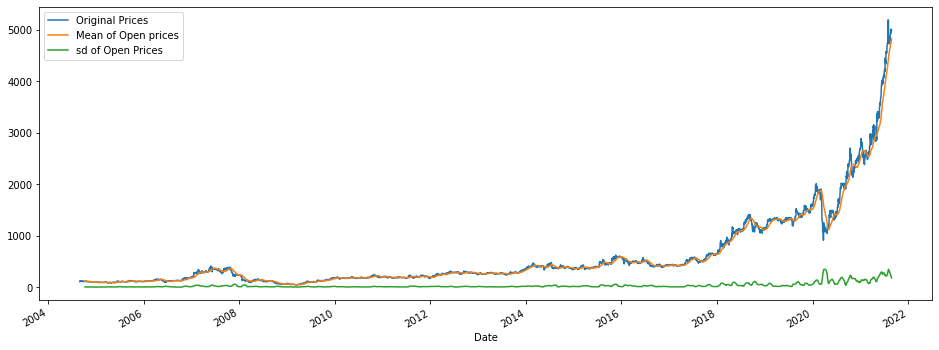

In [135]:
data_stock.Open.plot(figsize=(16,6), label="Original Prices")
data_stock.rolling(window=30).mean()['Open'].plot(label="Mean of Open prices")
data_stock.rolling(window=30).std()['Open'].plot(label="sd of Open Prices")
plt.legend()

In [134]:
# Interactive graph for rolling mean, std
import plotly.express as px

df = data_stock.copy()
df['category'] = 'original'

df_temp = data_stock.rolling(window=30).mean()
df_temp['category'] = 'rolling_mean'

df = pd.concat([df, df_temp])

df_temp = data_stock.rolling(window=30).std()
df_temp['category'] = 'rolling_std'

df = pd.concat([df, df_temp])

fig = px.line(df, x= df.index, y = df.Open, color='category')
fig.show()


#### Data Preprocessing

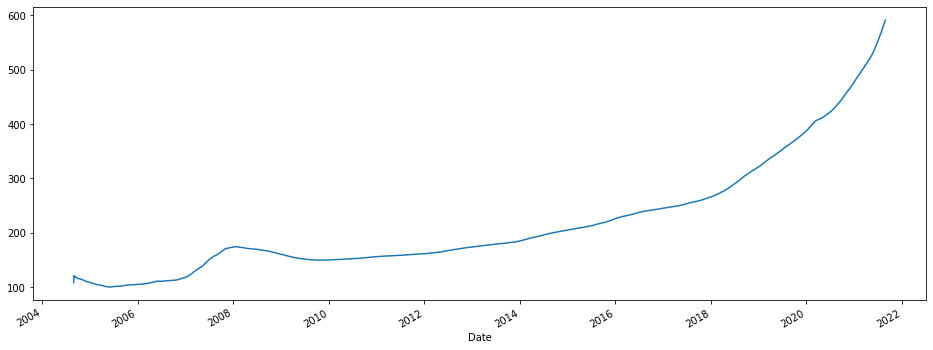

In [30]:
# Min observation per window=1
data_stock['Open'].expanding(min_periods=1).mean().plot(figsize=(16,6))

### train test split

In [170]:
##splitting dataset into train and test split
training_size = int(len(data_stock)*0.95)
test_size = len(data_stock) - training_size #0.35 percent of data for testing
train_set, test_set = pd.DataFrame(data_stock.iloc[0:training_size,0]), pd.DataFrame(data_stock.iloc[training_size:len(data_stock),0])

In [171]:
# we will work with open prices
# train_set = data_stock['Open']
# train_set = pd.DataFrame(train_set)
train_set.head()

,Open
Date,
2004-08-30,108.000000
2004-08-31,128.000000
2004-09-01,124.900002
2004-09-02,122.666664
2004-09-03,118.666664


In [172]:
test_set.head()

,Open
Date,
2020-10-22,2521.050049
2020-10-23,2500.000000
2020-10-26,2365.000000
2020-10-27,2180.000000
2020-10-28,2228.699951


In [173]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler

In [174]:
# Feature Scaling: Normalization (converting to a range 0-1)
from sklearn.preprocessing import MinMaxScaler
min_max_sc = MinMaxScaler(feature_range = (0,1))
train_set_scaled = min_max_sc.fit_transform(train_set)
len(train_set_scaled)

3982

In [175]:
# Say our data is
# 120, 130, 125, 140, 150

#    x_train    y_train
# f1	f2	f3	  o/p
# 120	130	125	  140
# 130 125 140   150

# in the above example, timestep=3
# in our use case, we considered timestep=60

In [176]:
# we will pick 60 data price points and then predict the 61th data point
x_train = []
y_train = []

for i in range(60, 2724):
    x_train.append(train_set_scaled[i-60:i, 0]) #0-59th data points
    y_train.append(train_set_scaled[i,0]) #60th data point

x_train, y_train = np.array(x_train), np.array(y_train)
x_train


array([[0.02426865, 0.03179381, 0.03062741, ..., 0.02097012, 0.02171009,
        0.02228702],
       [0.03179381, 0.03062741, 0.0297871 , ..., 0.02171009, 0.02228702,
        0.02168501],
       [0.03062741, 0.0297871 , 0.02828207, ..., 0.02228702, 0.02168501,
        0.02176026],
       ...,
       [0.12920703, 0.12672373, 0.12866147, ..., 0.15847992, 0.15793434,
        0.15953344],
       [0.12672373, 0.12866147, 0.12773963, ..., 0.15793434, 0.15953344,
        0.15821654],
       [0.12866147, 0.12773963, 0.12753269, ..., 0.15953344, 0.15821654,
        0.15166965]])

In [177]:
x_train.shape

(2664, 60)

In [178]:
y_train.shape

(2664,)

In [179]:
# Reshaping:
# before applying LSTM: we need to reshape data into 3 dimentional numpy array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2664, 60, 1)

In [180]:
x_train

array([[[0.02426865],
        [0.03179381],
        [0.03062741],
        ...,
        [0.02097012],
        [0.02171009],
        [0.02228702]],

       [[0.03179381],
        [0.03062741],
        [0.0297871 ],
        ...,
        [0.02171009],
        [0.02228702],
        [0.02168501]],

       [[0.03062741],
        [0.0297871 ],
        [0.02828207],
        ...,
        [0.02228702],
        [0.02168501],
        [0.02176026]],

       ...,

       [[0.12920703],
        [0.12672373],
        [0.12866147],
        ...,
        [0.15847992],
        [0.15793434],
        [0.15953344]],

       [[0.12672373],
        [0.12866147],
        [0.12773963],
        ...,
        [0.15793434],
        [0.15953344],
        [0.15821654]],

       [[0.12866147],
        [0.12773963],
        [0.12753269],
        ...,
        [0.15953344],
        [0.15821654],
        [0.15166965]]])

#### Feature Extraction

In [181]:
# features to be fed to NN

## Building the RNN
# Importing the Keras libraries and packages
# Keras is Tensorflow's high level API
 
from keras.models import Sequential # basically a linear stack of layers, using which we can build sequential model by passing a list to it
from keras.layers import Dense # regular deeply connected NN layer, a matrix vector multiplication
from keras.layers import LSTM 
from keras.layers import Dropout # dropout is a regularization technique for reducing overfitting in NN


In [182]:
# Initialising the RNN
regressor = Sequential()

### Training the NN

In [183]:
# Adding the first LSTM layer and 
# The below is stacked LSTM model
# some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# units - Positive integer, dimensionality of the output space.
# return_sequences --	Boolean. Whether to return the last output. in the output sequence, or the full sequence. Default: False.


# Adding a second LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units=1)) # units=1, as we need only 1 output

In [184]:
# compiling the RNN
regressor.compile(optimizer = 'adam', loss='mean_squared_error')

regressor.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)               

In [185]:
## Optimizer: greatly affects how fast the algorithm converges to min. value
# Adam (Adaptive Movement Estimation)

## Regularization: to avoid weights to get too large / avoiding overfitting.
# Tikhonov regularization

# Epoch - a frame of time in ML, the number of passes through the entire training dataset the ML algorithm has completed
# Batch size - number of training examples utilized in a single iterations. 32 is good size



# Fitting the RNN to the Training set
regressor.fit(x_train, y_train, epochs=100, batch_size = 32)

Epoch 1/100
84/84 [==============================] - 17s 122ms/step - loss: 5.3390e-04
Epoch 2/100
84/84 [==============================] - 10s 122ms/step - loss: 1.2567e-04
Epoch 3/100
84/84 [==============================] - 10s 123ms/step - loss: 1.0637e-04
Epoch 4/100
84/84 [==============================] - 10s 122ms/step - loss: 1.0109e-04
Epoch 5/100
84/84 [==============================] - 10s 122ms/step - loss: 9.2583e-05
Epoch 6/100
84/84 [==============================] - 10s 123ms/step - loss: 9.1776e-05
Epoch 7/100
84/84 [==============================] - 10s 122ms/step - loss: 8.8741e-05
Epoch 8/100
84/84 [==============================] - 10s 122ms/step - loss: 8.2377e-05
Epoch 9/100
84/84 [==============================] - 10s 123ms/step - loss: 8.1883e-05
Epoch 10/100
84/84 [==============================] - 10s 122ms/step - loss: 6.7110e-05
Epoch 11/100
84/84 [==============================] - 10s 122ms/step - loss: 7.6136e-05
Epoch 12/100
84/84 [=====================

In [186]:
min_max_sc.inverse_transform(regressor.predict(x_train)).shape

(2664, 1)

In [187]:
# predicting training error
import math
from sklearn.metrics import mean_squared_error

print(math.sqrt(mean_squared_error(y_train, min_max_sc.inverse_transform(regressor.predict(x_train)))))

247.0422511375231


In [188]:
# Taking the test data, data from recent or time frame after the training time frame
data_test = test_set.copy()

In [189]:
real_stock_prices = data_test.iloc[:,0].values # Open stock price
real_stock_prices.shape

(210,)

In [190]:
test_set = data_test['Open']
test_set = pd.DataFrame(test_set)

In [191]:
# Getting the predicted stock prices
data_total = pd.concat((train_set['Open'], test_set['Open']), axis=0)
inputs = data_total[len(data_total) - len(data_test) - 60:].values # 60 data points from training, and rest from test

inputs = inputs.reshape(-1, 1) # only one column
inputs = min_max_sc.transform(inputs)
inputs.shape

(270, 1)

In [193]:
x_test = []
# y_test = []
for i in range(60,270):
  x_test.append(inputs[i-60:i,0])
  # y_test.append(inputs[i,0]) -- is the first test value; which we have already stored in real_stock_prices

In [ ]:
# predicting stock prices
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predicted_stock_price = regressor.predict(x_test)
predicted_stock_price #scaled prices
# predicted_stock_price.shape #(1468, 1)

In [ ]:
predicted_stock_price = min_max_sc.inverse_transform(predicted_stock_price) #inverse_transform, to get it out of matrices form
# predicted_stock_price.shape #(1468, 1)
predicted_stock_price

In [196]:
# converting numpy array to pandas dataframe
predicted_stock_price = pd.DataFrame(predicted_stock_price, columns=['Open'])
predicted_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    210 non-null    float32
dtypes: float32(1)
memory usage: 968.0 bytes


In [197]:
predicted_stock_price.head()

,Open
0,2078.546875
1,2037.671509
2,2025.911011
3,1937.488281
4,1820.234619


In [198]:
# Finding error
from sklearn.metrics import mean_squared_error
import math
print(math.sqrt(mean_squared_error(real_stock_prices, predicted_stock_price.Open)))

983.2528749429816


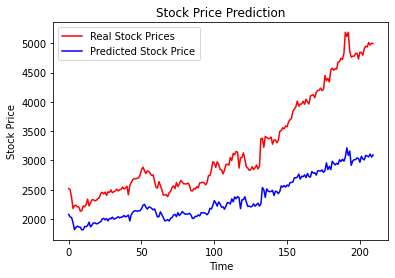

In [199]:
# Visualisation of results
plt.plot(real_stock_prices, color='red', label='Real Stock Prices')
plt.plot(predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [84]:
## It can be clearly seen, that the sudden jump in stock price couldn't be predicted